<a href="https://colab.research.google.com/github/jeanlucjackson/w266_final_project/blob/main/code/sandboxes/RR/rr_evaluation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

from pprint import pprint

pd.set_option("precision", 5)
sns.set_theme()

In [4]:
evaluation_root = "/content/drive/MyDrive/w266 NLP Final Project/Evaluation/"
filename = evaluation_root + "evaluation_database.json"

evaluation_df = pd.read_json(filename)

In [5]:
evaluation_df.columns

Index(['prediction_set', 'base_model', 'trained_on', 'tested_on', 'nickname',
       'hyperparameter', 'target', 'prediction', 'bleu', 'rouge1', 'rouge2',
       'rougeL', 'rougeLsum', 'meteor', 'bertscore-precision',
       'bertscore-recall', 'bertscore-f1', 'use', 'bleurt'],
      dtype='object')

In [6]:
evaluation_exclusions = [
    "rouge1",
    "rouge2",
    "rougeLsum",
    "bertscore-precision",
    "bertscore-recall",
    "bleurt",
]
evaluation_df = evaluation_df.drop(columns=evaluation_exclusions)

In [7]:
evaluation_metrics = evaluation_df.select_dtypes(exclude="object").columns
evaluation_metrics

Index(['bleu', 'rougeL', 'meteor', 'bertscore-f1', 'use'], dtype='object')

In [8]:
# Apply this mask to remove all samples from non default inference sets
default_hyperparameter_mask = [
    sample["defaults"] for sample in evaluation_df.hyperparameter
]

### BART vs T5

In the end, it is hard to distinguish BART from T5, with a slight edge going to T5.



We built 5 BART models and 5 T5 models.

Each set of 5 models includes one model trained on each of our datasets plus one trained on all of our datasets.

We ran the validation sets from each of our datasets on each of our ten models yielding 40 sets of predictions.

#### In The Aggregate

We group the prediction sets by base model and calculate the mean for each metric.

In every case, the BART models outperform the T5 models.

We applied Welch's t-test to the metric distributions between the two models and, in each case, found $p$ values of less than .05 and reject the hypothesis that the distributions have equal means.

In [9]:
df = evaluation_df[default_hyperparameter_mask]
df.groupby(["base_model"]).mean()
df_T5 = df[df["base_model"] == "T5"]
df_BART = df[df["base_model"] == "bart"]

For All Predictions Made


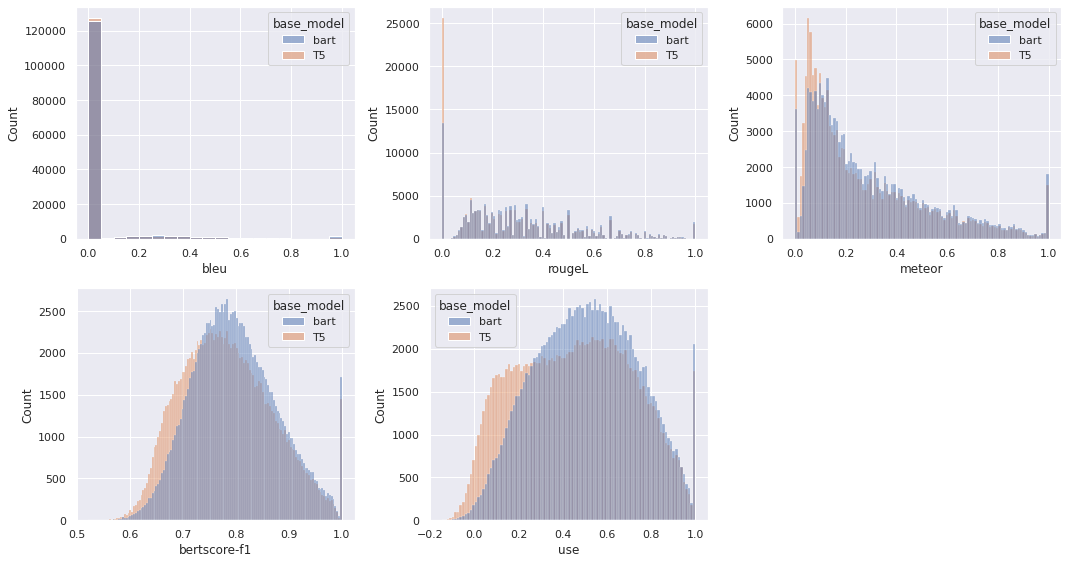

In [10]:
print("For All Predictions Made")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, metric in zip(axes.flat, evaluation_metrics):
    sns.histplot(x=metric, data=df, hue="base_model", ax=ax)
list(axes.flat)[-1].remove()
plt.tight_layout()
plt.show()

In [13]:
reject_count = 0
fail_to_reject_count = 0

print("Reject the null hypothesis except where noted otherwise\n")

for metric in evaluation_metrics:

    p = st.ttest_ind(df_T5[metric], df_BART[metric], equal_var=False)[1]

    if p <= 0.05:
        reject_null = ""
        reject_count += 1
    else:
        reject_null = "***FAIL TO REJECT THE NULL***"
        fail_to_reject_count += 1

    print(f"metric: {metric} Welch's t-test p value {p}, {reject_null}")

print(
    f"\nreject the null: {reject_count}, fail to reject the null:  {fail_to_reject_count}"
)

Reject the null hypothesis except where noted otherwise

metric: bleu Welch's t-test p value 1.9791640175347386e-23, 
metric: rougeL Welch's t-test p value 0.0, 
metric: meteor Welch's t-test p value 4.240592742194901e-230, 
metric: bertscore-f1 Welch's t-test p value 0.0, 
metric: use Welch's t-test p value 0.0, 

reject the null: 5, fail to reject the null:  0


In [14]:
bart_wins = 0
t5_wins = 0

print("BART wins the comparison except where noted otherwise\n")

for metric in evaluation_metrics:
    print(f"metric: {metric}", end=" ")
    T5 = df_T5[metric].mean()
    BART = df_BART[metric].mean()

    if BART > T5:
        print("")
        bart_wins += 1
    else:
        print("\t***T5 wins***")
        t5_wins += 1

print()
print(f"BART wins: {bart_wins} T5 wins: {t5_wins}")

BART wins the comparison except where noted otherwise

metric: bleu 
metric: rougeL 
metric: meteor 
metric: bertscore-f1 
metric: use 

BART wins: 5 T5 wins: 0


#### Per Training Set

We group the prediction sets by base model and training set and calculate the mean for each metric.

We have five metrics and five training sets (four individual plus amalgam).

In 13 of those 25 cases, the differences in the distributions are not statistically significant.

In the 12 cases where the differences in the distributions are significant, BART outperforms T5 for all 5 metrics on each of the QuAC and TriviaQA trained models. On the other hand, T5 outperforms BART on the amalgam trained dataset for Bertscore-F1 and on the NQ trained dataset for USE.

So, when we look just at the amalgam trained models, the results are indistinguishable across every metric other than bertscore-f1, where T5 outperforms BART.

In [15]:
df = evaluation_df[default_hyperparameter_mask]
df = df.groupby(["trained_on", "base_model"]).mean()
df = df.reset_index()
training_sets = df.trained_on.unique()
df

,trained_on,base_model,bleu,rougeL,meteor,bertscore-f1,use
0,amalgam,T5,0.10053,0.39166,0.38429,0.83285,0.58573
1,amalgam,bart,0.09873,0.38872,0.38604,0.83153,0.58404
2,nq,T5,0.02354,0.29801,0.22997,0.76924,0.50103
3,nq,bart,0.02499,0.29348,0.22864,0.76848,0.50252
4,quac,T5,0.00495,0.09174,0.09777,0.70548,0.17930
5,quac,bart,0.02474,0.26015,0.22003,0.78025,0.42917
6,squad,T5,0.06450,0.33603,0.32098,0.81201,0.52813
7,squad,bart,0.06580,0.33416,0.32217,0.81202,0.52879
8,triviaqa,T5,0.03592,0.26747,0.29125,0.79005,0.48495
9,triviaqa,bart,0.04471,0.29440,0.30900,0.79609,0.50747


In [16]:
reject = []
fail_to_reject = []

print("Reject the null hypothesis except where noted otherwise\n")

for training_set in training_sets:
    T5_set = df_T5[df_T5["trained_on"] == training_set]
    BART_set = df_BART[df_BART["trained_on"] == training_set]

    for metric in evaluation_metrics:
        p = st.ttest_ind(T5_set[metric], BART_set[metric], equal_var=False)[1]
        if p <= 0.05:
            reject_null = ""
            reject.append((training_set, metric))
        else:
            reject_null = "***FAIL TO REJECT THE NULL"
            fail_to_reject.append((training_set, metric))

        print(
            f"training set: {training_set} metric: {metric} p value: {p}, {reject_null}"
        )

print(
    f"\nreject the null: {len(reject)}, fail to reject the null:  {len(fail_to_reject)}"
)

print("reject the null:")
pprint(reject)

Reject the null hypothesis except where noted otherwise

training set: amalgam metric: bleu p value: 0.33155457217624207, ***FAIL TO REJECT THE NULL
training set: amalgam metric: rougeL p value: 0.16550668332605217, ***FAIL TO REJECT THE NULL
training set: amalgam metric: meteor p value: 0.41766204420585396, ***FAIL TO REJECT THE NULL
training set: amalgam metric: bertscore-f1 p value: 0.04764397222876399, 
training set: amalgam metric: use p value: 0.38716485857314165, ***FAIL TO REJECT THE NULL
training set: nq metric: bleu p value: 0.11419945871024073, ***FAIL TO REJECT THE NULL
training set: nq metric: rougeL p value: 0.010631776312341407, 
training set: nq metric: meteor p value: 0.4402382966513929, ***FAIL TO REJECT THE NULL
training set: nq metric: bertscore-f1 p value: 0.22290603302400405, ***FAIL TO REJECT THE NULL
training set: nq metric: use p value: 0.41311947824287576, ***FAIL TO REJECT THE NULL
training set: quac metric: bleu p value: 5.842527018416679e-125, 
training set

In [17]:
bart_wins = 0
t5_wins = 0

print("BART wins the comparison except where noted otherwise\n")

for training_set, metric in reject:
    print(f"training set: {training_set}\tmetric: {metric}", end=" ")
    T5 = df[(df["base_model"] == "T5") & (df["trained_on"] == training_set)][
        metric
    ].values[0]
    BART = df[(df["base_model"] == "bart") & (df["trained_on"] == training_set)][
        metric
    ].values[0]

    if BART > T5:
        print("")
        bart_wins += 1
    else:
        print("\t***T5 wins***")
        t5_wins += 1

print()
print(f"BART wins = {bart_wins} T5 wins = {t5_wins}")

BART wins the comparison except where noted otherwise

training set: amalgam	metric: bertscore-f1 	***T5 wins***
training set: nq	metric: rougeL 	***T5 wins***
training set: quac	metric: bleu 
training set: quac	metric: rougeL 
training set: quac	metric: meteor 
training set: quac	metric: bertscore-f1 
training set: quac	metric: use 
training set: triviaqa	metric: bleu 
training set: triviaqa	metric: rougeL 
training set: triviaqa	metric: meteor 
training set: triviaqa	metric: bertscore-f1 
training set: triviaqa	metric: use 

BART wins = 10 T5 wins = 2


In [18]:
df = evaluation_df[default_hyperparameter_mask]
df = df[df["trained_on"] == "amalgam"]

For Amalgam Trained Models


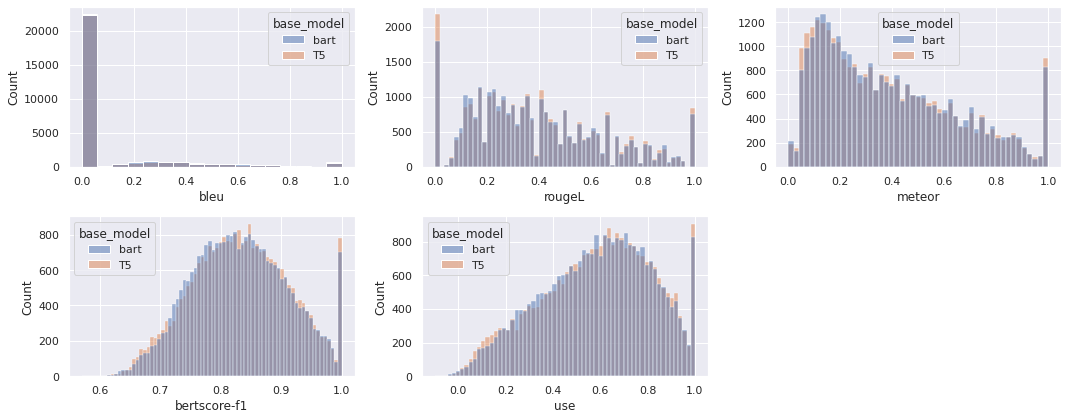

In [19]:
print("For Amalgam Trained Models")
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, metric in zip(axes.flat, evaluation_metrics):
    sns.histplot(x=metric, data=df, hue="base_model", ax=ax)
list(axes.flat)[-1].remove()
plt.tight_layout()

### Which Model Is Best?

Next we look at each of our models to see which performs the best when we consider every inference made with that model.  We consider each of our evaluation metrics.

For each metric, the top two models are always the amalgram trained models and the next two models are always the squad trained models.

As we discussed above, the only statistically significant difference between the amalgam trained models is that T5 outperforms BART on bertscore-F1 and there is not statistically significant difference between how the SQuAD trained models perform on any metric.

So, our amalgam trained models are at the top with a slight edge to T5 over BART on those two models.

In [20]:
df = evaluation_df[default_hyperparameter_mask]
df = df.groupby(["base_model", "trained_on"]).mean()
for metric in evaluation_metrics:
    print(metric)
    pprint(df[metric].sort_values(ascending=False)[:5])
    print()

bleu
base_model  trained_on
T5          amalgam       0.10053
bart        amalgam       0.09873
            squad         0.06580
T5          squad         0.06450
bart        triviaqa      0.04471
Name: bleu, dtype: float64

rougeL
base_model  trained_on
T5          amalgam       0.39166
bart        amalgam       0.38872
T5          squad         0.33603
bart        squad         0.33416
T5          nq            0.29801
Name: rougeL, dtype: float64

meteor
base_model  trained_on
bart        amalgam       0.38604
T5          amalgam       0.38429
bart        squad         0.32217
T5          squad         0.32098
bart        triviaqa      0.30900
Name: meteor, dtype: float64

bertscore-f1
base_model  trained_on
T5          amalgam       0.83285
bart        amalgam       0.83153
            squad         0.81202
T5          squad         0.81201
bart        triviaqa      0.79609
Name: bertscore-f1, dtype: float64

use
base_model  trained_on
T5          amalgam       0.58573
bart       

In [36]:
df = evaluation_df[default_hyperparameter_mask]
df = df[df['base_model']=='T5']
df = df.groupby(["trained_on"]).mean().sort_values(by='use', ascending=False)
df = df.multiply(100).reset_index()


In [37]:
pd.set_option('display.precision', 2)
df

,trained_on,bleu,rougeL,meteor,bertscore-f1,use
0,amalgam,10.05,39.17,38.43,83.29,58.57
1,squad,6.45,33.60,32.10,81.20,52.81
2,nq,2.35,29.80,23.00,76.92,50.10
3,triviaqa,3.59,26.75,29.13,79.01,48.49
4,quac,0.50,9.17,9.78,70.55,17.93


In [39]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrr}\n\\toprule\ntrained\\_on &      bleu &    rougeL &    meteor &  bertscore-f1 &       use \\\\\n\\midrule\n   amalgam & 10.053108 & 39.166116 & 38.429295 &     83.285436 & 58.572591 \\\\\n     squad &  6.450104 & 33.603497 & 32.098022 &     81.201079 & 52.812646 \\\\\n        nq &  2.353728 & 29.801388 & 22.997445 &     76.923511 & 50.102933 \\\\\n  triviaqa &  3.592048 & 26.747323 & 29.125416 &     79.005200 & 48.494866 \\\\\n      quac &  0.495437 &  9.173745 &  9.776580 &     70.548394 & 17.929878 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [38]:
pd.reset_option('display.precision')
df

,trained_on,bleu,rougeL,meteor,bertscore-f1,use
0,amalgam,10.053108,39.166116,38.429295,83.285436,58.572591
1,squad,6.450104,33.603497,32.098022,81.201079,52.812646
2,nq,2.353728,29.801388,22.997445,76.923511,50.102933
3,triviaqa,3.592048,26.747323,29.125416,79.005200,48.494866
4,quac,0.495437,9.173745,9.776580,70.548394,17.929878


### Sequentially Trained Blended Models

We compare the sn, snq and snqt models using the same methodology applied in the last section.  We look at every inference made and then each metric.

For all metrics, the snqt model is the highest performer of the three sequentially trained models.  There is some variation between the second and third performers.  All differences are statistically significant.

While snqt is the best of the sequentially trained models, it never outperforms the blended model that was trained on shuffled data.

In [ ]:
filename = evaluation_root + "evaluation_database_snqt.json"

evaluation_df_2 = pd.read_json(filename)

In [ ]:
default_hyperparameter_mask_2 = [
    sample["defaults"] for sample in evaluation_df_2.hyperparameter
]
evaluation_df_2 = evaluation_df_2.drop(columns=evaluation_exclusions)

#### snqt outperforms sn and snq for each metric, all differences are statistically significant.

In [ ]:
df = evaluation_df_2[default_hyperparameter_mask_2]
df = (
    df.groupby(["base_model", "trained_on"])
    .mean()
    .sort_values(by="use", ascending=False)
)
df

In [ ]:
for metric in evaluation_metrics:
    print(metric)
    pprint(df[metric].sort_values(ascending=False)[:3])
    print()

In [ ]:
df = evaluation_df_2[default_hyperparameter_mask_2]

snqt_set = df[df["trained_on"] == "snqt"]

reject = []
fail_to_reject = []

print("Reject the null hypothesis except where noted otherwise\n")

for training_set in ["sn", "snq"]:
    candidate_set = df[df["trained_on"] == training_set]

    for metric in evaluation_metrics:
        p = st.ttest_ind(snqt_set[metric], candidate_set[metric], equal_var=False)[1]
        if p <= 0.05:
            reject_null = ""
            reject.append((training_set, metric))
        else:
            reject_null = "***FAIL TO REJECT THE NULL"
            fail_to_reject.append((training_set, metric))

        print(
            f"training set: {training_set} metric: {metric} p value: {p}, {reject_null}"
        )

print(
    f"\nreject the null: {len(reject)}, fail to reject the null: {len(fail_to_reject)}"
)

#### BART amalgam outperforms BART snqt on every metric and in each case, the performance difference is statistically significant.

In [ ]:
df_1 = df_BART[df_BART["trained_on"] == "amalgam"]
df_2 = evaluation_df_2[evaluation_df_2["trained_on"] == "snqt"]
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)
df = df.groupby(["base_model", "trained_on"]).mean()
df

In [ ]:
reject = []
fail_to_reject = []

print("Reject the null hypothesis except where noted otherwise\n")

for metric in evaluation_metrics:
    p = st.ttest_ind(df_1[metric], df_2[metric], equal_var=False)[1]
    if p <= 0.05:
        reject_null = ""
        reject.append((metric))
    else:
        reject_null = "***FAIL TO REJECT THE NULL"
        fail_to_reject.append((metric))

    print(f"metric: {metric} p value: {p}, {reject_null}")

print(
    f"\nreject the null: {len(reject)}, fail to reject the null:  {len(fail_to_reject)}"
)

In [ ]:
amalgam_wins = 0
snqt_wins = 0
df = df.reset_index()
print("Amalgam wins the comparison except where noted otherwise\n")

for metric in reject:
    print(f"metric: {metric}", end=" ")
    amalgam = df[(df["trained_on"] == "amalgam")][metric].values[0]
    snqt = df[(df["trained_on"] == "snqt")][metric].values[0]

    if amalgam > snqt:
        print("")
        amalgam_wins += 1
    else:
        print("\t***snqt wins***")
        snqt_wins += 1

print()
print(f"amalgam wins = {amalgam_wins} snqt wins = {snqt_wins}")

In [ ]:
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)
print("Compare BART Amalgam v BART snqt (all inferences)")
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, metric in zip(axes.flat, evaluation_metrics):
    sns.histplot(x=metric, data=df, hue="trained_on", ax=ax)
list(axes.flat)[-1].remove()
plt.tight_layout()

### BART SQuAD compared to BART snqt

Does BART snqt manage to outperform BART SQuAD even though it does not outperform BART amalgam?

Not really.  BART SQuAD outperforms BART snqt across the board with the exception of meteor.

All differences are statistically significant.

In [ ]:
df_3 = df_BART[df_BART["trained_on"] == "squad"]
df = pd.concat([df_2, df_3], axis=0, ignore_index=True)
df = (
    df.groupby(["base_model", "trained_on"])
    .mean()
    .sort_values(by="use", ascending=False)
)
df

In [ ]:
reject = []
fail_to_reject = []

print("Reject the null hypothesis except where noted otherwise\n")

for metric in evaluation_metrics:
    p = st.ttest_ind(df_2[metric], df_3[metric], equal_var=False)[1]
    if p <= 0.05:
        reject_null = ""
        reject.append((metric))
    else:
        reject_null = "***FAIL TO REJECT THE NULL"
        fail_to_reject.append((metric))

    print(f"metric: {metric} p value: {p}, {reject_null}")

print(
    f"\nreject the null: {len(reject)}, fail to reject the null:  {len(fail_to_reject)}"
)

In [ ]:
snqt_wins = 0
squad_wins = 0
df = df.reset_index()

for metric in reject:
    print(f"metric: {metric}", end=" ")
    snqt = df[(df["trained_on"] == "snqt")][metric].values[0]
    squad = df[(df["trained_on"] == "squad")][metric].values[0]

    if squad > snqt:
        print("\tSQuAD trained wins")
        squad_wins += 1
    else:
        print("\tsnqt trained wins")
        snqt_wins += 1

print()
print(f"SQuAD wins = {squad_wins} snqt wins = {snqt_wins}")

In [ ]:
df = pd.concat([df_2, df_3], axis=0, ignore_index=True)
print("Compare BART snqt v BART SQuAD (all inferences)")
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, metric in zip(axes.flat, evaluation_metrics):
    sns.histplot(x=metric, data=df, hue="trained_on", ax=ax)
list(axes.flat)[-1].remove()
plt.tight_layout()

### Beam search and no repeat ngrams on TriviaQA



We ran the full suite of inference tests on our BART models with beam search and the use of a no repeat ngram parameters.  The primnary motivation for this experiment was to see if we would get better performance on the TriviaQA validation set.  As shown below, our top performance on each metric we consider remains the model trained on the amalgamated dataset and running inference without beam search or the use of a no repeat ngram parameter.

In [ ]:
for metric in evaluation_metrics:
    df = df_BART[["nickname", "trained_on", "tested_on", metric]]
    df = df[df.tested_on == "triviaqa"]
    display(
        df.groupby(["nickname", "trained_on", "tested_on"])
        .mean()
        .sort_values([metric], ascending=False)[:4]
    )

### Kendall's Tau

In [ ]:
df = evaluation_df[default_hyperparameter_mask]
baseline = (
    df[
        (df["base_model"] == "T5")
        & (df["trained_on"] == "squad")
        & (df["tested_on"] == "squad")
    ]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
)
baseline

In [ ]:
nq_df = (
    df[df["tested_on"] == "nq"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

nq_df

In [ ]:
quac_df = (
    df[df["tested_on"] == "quac"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

quac_df

In [ ]:
squad_df = (
    df[df["tested_on"] == "squad"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

squad_df

In [ ]:
triviaqa_df = (
    df[df["tested_on"] == "triviaqa"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

triviaqa_df

In [ ]:
metrics = list(squad_df.columns)
datasets = df["tested_on"].unique()
print(f"metrics = {metrics} \ndatasets = {datasets}")

In [ ]:
# We gather the predictions for a validation dataset
# Sort the rows from best to worst scores on one metric
# Then we build ranking vectors for all metrics

rankings = {}

for dataset in datasets:
    slice_df = (
        df[df["tested_on"] == dataset]
        .groupby(["base_model", "trained_on", "tested_on"])
        .mean()
        .sort_values(by=["bleu"], ascending=False)
    )
    for metric in metrics:
        vector = [
            sorted(slice_df[metric], reverse=True).index(x) + 1
            for x in slice_df[metric]
        ]
        rankings[(dataset, metric)] = vector

In [ ]:
rankings

In [ ]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = {metric: rankings[(dataset, metric)] for metric in metrics}
vectors

In [ ]:
ranking_df = {dataset: pd.DataFrame(vectors[dataset]) for dataset in datasets}
for k, v in ranking_df.items():
    print(k)
    print(v)

In [ ]:
kendall_df = {
    dataset: ranking_df[dataset].corr(method="kendall") for dataset in datasets
}
for k, v in kendall_df.items():
    print(k)
    print(v)

In [ ]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(kendall_df["squad"].corr(), dtype=bool))
mask

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

for ax, dataset in zip(axes.flat, datasets):
    sns.heatmap(kendall_df[dataset], mask=mask, cmap="Blues", ax=ax).set(title=dataset)

fig.tight_layout()

plt.show()

### Cosine Similarity

In [ ]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = [rankings[(dataset, metric)] for metric in metrics]

In [ ]:
similarity = {}
for dataset in datasets:
    similarity[dataset] = pd.DataFrame(
        cosine_similarity(vectors[dataset]), columns=metrics, index=metrics
    )

In [ ]:
similarity["nq"]

In [ ]:
similarity["quac"]

In [ ]:
similarity["squad"]

In [ ]:
similarity["triviaqa"]

In [ ]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(similarity["squad"].corr(), dtype=bool))

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

for ax, dataset in zip(axes.flat, datasets):
    sns.heatmap(similarity[dataset], mask=mask, cmap="coolwarm", ax=ax).set(
        title=dataset
    )

fig.tight_layout()

plt.show()

### Black

In [ ]:
!pip install black[jupyter]

In [ ]:
!black "/content/drive/MyDrive/Colab Notebooks/rr_evaluation_sandbox.ipynb"